# Analysis of mouse single cell hematopoietic populations - RNA-Seq anaysis

__Author__: Elisabeth F. Heuston

## Purpose

Single cell transcriptional and clustering analysis of LSK, CMP, MEP, and GMP data presented in Heuston et al., 2021  

This notebook contains the python workflow to analyze bulk RNS-Seq data and pertains to:
* Figure 5A
* Supplemental Figures 7A, 7B, 7C

Raw data for this publication are available to download from the GEO Project GSE168260 at https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE168260  
Raw data previously published in Heuston et al., 2018, is available to download from www.usevision.org

## Workbook setup

### Import python3.7 modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
import os, re, glob
import seaborn as sns

### Functions

### create_table_of_averages

In [2]:
def create_column_dictionary(counts_table):
    column_dict = {}
    for name in counts_table.columns:
        m = re.split('(_r\d+)$', name)
        if any(['_r' in element for element in m]):
            column_dict.setdefault(m[0], [])
            column_dict[m[0]].append(name)
    return column_dict
    print("Created column dictionary")
    

def create_table_of_averages(counts_table):
    column_dict = {}
    column_dict = create_column_dictionary(counts_table)
    table_of_averages = pd.DataFrame()
    for celltype in column_dict.keys():
        table_of_averages[celltype + 'avg'] = counts_table[column_dict[celltype]].mean(axis = 1)
    return table_of_averages
    print("Created table of average counts")
    

## STAR/RSEM pipeline

### STAR command

### RSEM command

### Generate TPM summary table

## Gene set enrichment analysis

Ranked gene lists and gmt files are generated in R (see __.X__)  
Calculates are performed by edgeR and DESeq2

Gene set enrichment analysis is performed in GSEA (Broad Institute, version 4.1.0) and is called via the command line below:

### GSEA command

In [4]:
gmt = "LSK_CMP_GMP_EB_MK.gmt"
rnk_list = glob.glob('*_2FC-rankedGSEA.rnk')

gsea_cmds = []

for rnk_file in rnk_list:
    outname = re.match('^(\w+)(?=-)', rnk_file)[0]
    outgmt = os.path.basename(re.split('\.',gmt)[0])
    outfile = '_'.join((outname, outgmt))
    gsea_cmd = ''.join(('~/Desktop/GSEA_4.1.0/gsea-cli.sh GSEAPreranked -gmx ', 
                        gmt,
                        ' -collapse No_Collapse -mode Max_probe -norm meandiv -nperm 20000 -rnk ', 
                         rnk_file, 
                        ' -scoring_scheme weighted -rpt_label ',
                        outfile, 
                        ' -create_svgs false -include_only_symbols true -make_sets true -plot_top_x 20 -rnd_seed timestamp -set_max 500 -set_min 5 -zip_report false -out ./'))
    gsea_cmds.append(gsea_cmd)

file_position = 0
for cmd in gsea_cmds:
    os.system(cmd)
    print("finished", rnk_list[file_position])
    file_position = file_position + 1

finished c11vCMP_2FC-rankedGSEA.rnk
finished c17vCMP_2FC-rankedGSEA.rnk
finished c10vCMP_2FC-rankedGSEA.rnk
finished c3svCMP_2FC-rankedGSEA.rnk


In [5]:
# Search through GSEA directories for tsv summary files
file_list = []
for gsea_dir in os.listdir('./'):
    if re.match('c\d.+', gsea_dir) and os.path.isdir(gsea_dir):
        print('Searching', gsea_dir)
        for gsea_file in os.listdir(os.path.join(gsea_dir)):
            if bool(re.match('gsea.+na_[pos|neg].+.tsv', gsea_file)) == True:
                file_list.append(os.path.join(gsea_dir, gsea_file))
                
goAll_list = []
go_writelist = []

# Load summary files into go_alldf table
for file in file_list:
    filename =os.path.basename(re.match('(\w+?)(?=_LSK)', file)[0])

    df = pd.DataFrame()
    goAll_file = pd.read_csv(file, sep = '\t')
    goAll_file['File'] = filename
    df['Pathway'] = goAll_file['NAME']
    df['File'] = filename
    df['size'] = pd.to_numeric(goAll_file['SIZE'])
    df['NES'] = goAll_file['NES']
    df['FDR'] = goAll_file['FDR q-val']
    goAll_list.append(df)
    go_writelist.append(goAll_file)
go_alldf = pd.concat(goAll_list, axis = 0, ignore_index = True)

# Limit table to only entries with FDR <= 0.25
sig_goalldf = go_alldf[go_alldf['FDR'] <= 0.25].sort_values('Pathway')
sig_goalldf['NES'] = pd.to_numeric(sig_goalldf['NES'])
sig_goalldf = sig_goalldf.drop('FDR', axis = 1)
sig_goalldf['File'] = sig_goalldf['File'].apply(lambda x:  pd.Series(str(x).split("vC")[0]))
sig_goalldf = pd.melt(sig_goalldf, id_vars=['Pathway', 'File'])
sig_size = sig_goalldf[sig_goalldf['variable'] == 'size'].copy()
sig_size.drop('variable', inplace = True, axis = 1)
sig_size = sig_size.rename(columns = {'value': 'size'})
sig_nes = sig_goalldf[sig_goalldf['variable'] == 'NES'].copy()
sig_nes.drop('variable', inplace = True, axis = 1)
sig_nes = sig_nes.rename(columns = {'value': 'NES'})
sigDF = pd.merge(left = sig_size, right = sig_nes, left_on=['File', 'Pathway'], right_on = ['File', 'Pathway'])

# Format order of x and y axes
pathwayorder = ['LSK', 'CMP', 'GMP', 'MK', 'ERY']
fileorder = ['c3s', 'c10', 'c11', 'c17']
spacefiller = pd.DataFrame({'Pathway':['LSK'], 'File': ['c3s'], 'size': [0], 'NES':[0]})
sigDF = sigDF.append(spacefiller)
sigDF['Pathway'] = pd.Categorical(sigDF['Pathway'], categories=['LSK', 'CMP', 'GMP', 'MK', 'ERY'], ordered=True)
sigDF['File'] = pd.Categorical(sigDF['File'], categories=fileorder, ordered=True)

# Normalize size and NES score for plotting
sigDF = sigDF.sort_values(['File', 'Pathway'])
size_norm = sigDF['size']/sigDF['size'].max()
nes_norm = sigDF['NES']/sigDF['NES'].max()


Searching c3svCMP_2FC_LSK_CMP_GMP_EB_MK.GseaPreranked.1619196627718
Searching c10vCMP_2FC_LSK_CMP_GMP_EB_MK.GseaPreranked.1619196616375
Searching c17vCMP_2FC_LSK_CMP_GMP_EB_MK.GseaPreranked.1619196599950
Searching c11vCMP_2FC_LSK_CMP_GMP_EB_MK.GseaPreranked.1619196587734


#### Supplemental Figure 7A

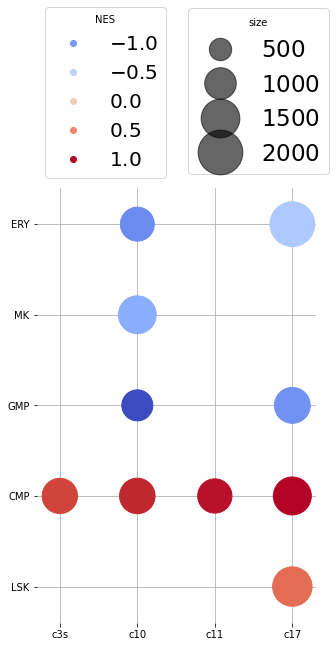

In [6]:
fig, ax = plt.subplots(figsize = (5,8))
scatter = ax.scatter(data = sigDF, x = 'File', y = 'Pathway', c = nes_norm, s = size_norm * 2000, cmap = 'coolwarm')
ax.margins(y = .1, x = .1)
ax.grid(True)
ax.set_axisbelow(True)
plt.box(on = None)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num = 5), loc="lower right", title="NES", bbox_to_anchor=(.5, 1), prop={'size': 20}) # note color is normalized
ax.add_artist(legend1)

# produce a legend with a cross section of sizes from the scatter
handles, labels = scatter.legend_elements(num =5, prop="sizes", alpha=0.6)
legend2 = ax.legend(handles, labels, loc="upper left", title="size", bbox_to_anchor=(.5,1.44), prop={'size': 23}) # note size is normalized

plt.show()


## Import RNA-Seq TPM summary table

RNA-Seq_TPM.txt is table of RSEM counts, with columns = samples and rows = genes  
This is generated by combining the .genes.results files from RSEM

In [7]:
TPM = pd.read_csv("RNA-Seq_TPM.txt", sep="\t", index_col=0)
TPM = TPM[~TPM.symbol.str.contains('|'.join(('^Gm\d{1,}a?$', 'Rik', '^[A-Z]{2,}', 'n-')))] # remove genes that won't map to HUGO symbols
TPM.head(2)

,symbol,CMP_r443,CMP_r448,C11_r1,C11_r2,C10_r1,C10_r2,C3_r1,C3_r2,C17_r1,C17_r2
gene_id,,,,,,,,,,,
ENSMUSG00000000001.4,Gnai3,24.17,18.36,47.77,32.91,88.07,55.99,110.57,68.26,57.77,54.34
ENSMUSG00000000003.15,Pbsn,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Combine replicates to get average expression for each cell type

In [8]:
TPM_avg = create_table_of_averages(TPM)
TPM_avg = TPM_avg.join(TPM['symbol'])
TPM_avg.head(2)

,CMPavg,C11avg,C10avg,C3avg,C17avg,symbol
gene_id,,,,,,
ENSMUSG00000000001.4,21.265,40.34,72.03,89.415,56.055,Gnai3
ENSMUSG00000000003.15,0.000,0.00,0.00,0.000,0.000,Pbsn


### Expression comparisons across CMP subpopulations

There are 15 comparisons to make.

Uniquely expressed (1):  
* C11 (not C10C3C17)
* C10 (not C11C3C17)
* C17 (not C11C10C3)
* C3 (not C11C10C17)

Shared (2):  
* C11C10 (not C3C17)
* C11C3 (not C10C17)
* C11C17 (not C10C3)
* C10C3 (not C11C17)
* C10C17 (not C11C3)
* C3C17 (not C11C10)

Shared (3):
* C10C3C17 (not C11)
* C11C3C17 (not C10)
* C11C10C17 (not C3)
* C11C10C3 (not C17)

Shared (4):
* C11C10C3C17

Create a dictionary to hold all the comparisons. Every dictionary key is a dataframe (table) filtered to include rows in which comparison matches the threshold cutoff.  
For example:  
> TPM10 [C11] = Every gene is expressed at least TPM = 10 in C11 but less than 10 in C10, C3, and C17  
> TPM10 [C3C17] = Every gene is expressed at least TPM = 10 in C3 and C17 but less than 10 in C10 and C11

In [9]:
count_threshold = 10
TPM10 = {}

TPM10['C11'] = TPM_avg[(TPM_avg['C11avg'] >= count_threshold) & (TPM_avg['C10avg'] < count_threshold) & (TPM_avg['C3avg'] < count_threshold) & (TPM_avg['C17avg'] < count_threshold)]
TPM10['C10'] = TPM_avg[(TPM_avg['C11avg'] < count_threshold) & (TPM_avg['C10avg'] >= count_threshold) & (TPM_avg['C3avg'] < count_threshold) & (TPM_avg['C17avg'] < count_threshold)]
TPM10['C17'] = TPM_avg[(TPM_avg['C11avg'] < count_threshold) & (TPM_avg['C10avg'] < count_threshold) & (TPM_avg['C3avg'] < count_threshold) & (TPM_avg['C17avg'] >= count_threshold)]
TPM10['C3'] = TPM_avg[(TPM_avg['C11avg'] < count_threshold) & (TPM_avg['C10avg'] < count_threshold) & (TPM_avg['C3avg'] >= count_threshold) & (TPM_avg['C17avg'] < count_threshold)]

TPM10['C11C10'] = TPM_avg[(TPM_avg['C11avg'] >= count_threshold) & (TPM_avg['C10avg'] >= count_threshold) & (TPM_avg['C3avg'] < count_threshold) & (TPM_avg['C17avg'] < count_threshold)]
TPM10['C11C3'] = TPM_avg[(TPM_avg['C11avg'] >= count_threshold) & (TPM_avg['C10avg'] < count_threshold) & (TPM_avg['C3avg'] >= count_threshold) & (TPM_avg['C17avg'] < count_threshold)]
TPM10['C11C17'] = TPM_avg[(TPM_avg['C11avg'] >= count_threshold) & (TPM_avg['C10avg'] < count_threshold) & (TPM_avg['C3avg'] < count_threshold) & (TPM_avg['C17avg'] >= count_threshold)]
TPM10['C10C3'] = TPM_avg[(TPM_avg['C11avg'] < count_threshold) & (TPM_avg['C10avg'] >= count_threshold) & (TPM_avg['C3avg'] >= count_threshold) & (TPM_avg['C17avg'] < count_threshold)]
TPM10['C10C17'] = TPM_avg[(TPM_avg['C11avg'] < count_threshold) & (TPM_avg['C10avg'] >= count_threshold) & (TPM_avg['C3avg'] < count_threshold) & (TPM_avg['C17avg'] >= count_threshold)]
TPM10['C3C17'] = TPM_avg[(TPM_avg['C11avg'] < count_threshold) & (TPM_avg['C10avg'] < count_threshold) & (TPM_avg['C3avg'] >= count_threshold) & (TPM_avg['C17avg'] >= count_threshold)]

TPM10['C10C3C17'] = TPM_avg[(TPM_avg['C11avg'] < count_threshold) & (TPM_avg['C10avg'] >= count_threshold) & (TPM_avg['C3avg'] >= count_threshold) & (TPM_avg['C17avg'] >= count_threshold)]
TPM10['C11C3C17'] = TPM_avg[(TPM_avg['C11avg'] >= count_threshold) & (TPM_avg['C10avg'] < count_threshold) & (TPM_avg['C3avg'] >= count_threshold) & (TPM_avg['C17avg'] >= count_threshold)]
TPM10['C11C10C17'] = TPM_avg[(TPM_avg['C11avg'] >= count_threshold) & (TPM_avg['C10avg'] >= count_threshold) & (TPM_avg['C3avg'] < count_threshold) & (TPM_avg['C17avg'] >= count_threshold)]
TPM10['C11C10C3'] = TPM_avg[(TPM_avg['C11avg'] >= count_threshold) & (TPM_avg['C10avg'] >= count_threshold) & (TPM_avg['C3avg'] >= count_threshold) & (TPM_avg['C17avg'] < count_threshold)]

TPM10['C11C10C3C17'] = TPM_avg[(TPM_avg['C11avg'] >= count_threshold) & (TPM_avg['C10avg'] >= count_threshold) & (TPM_avg['C3avg'] >= count_threshold) & (TPM_avg['C17avg'] >= count_threshold)]


### Count genes in the table

Create two new dictionaries for plotting data in Supplemental Figure 7B  
> num_genes = number of genes in each comparison  
> pct_CMP = percentage of genes in the comparison that are also expressed above the count threshold in CMP

Final figure will be a 4x4 grid where each box represents one of the comparisons

In [10]:
num_genes = {}
pct_CMP = {}

for key in TPM10.keys():
    fullDF = TPM10[key]
    cmpDF = fullDF[fullDF['CMPavg'] >= count_threshold]
    
    num_genes[key] = fullDF.shape[0]
    pct_CMP[key] = round(cmpDF.shape[0]/fullDF.shape[0]*100)

"keyorder" specifies which comparison goes in which box

In [11]:
keyorder = np.array([['C10', 'C11C10', 'C11', np.nan],
        ['C10C17', 'C11C10C17', 'C11C17', 'C17'],
        ['C10C3C17', 'C11C10C3C17', 'C11C3C17', 'C3C17'],
        ['C10C3', 'C11C10C3', 'C11C3', 'C3']
       ], dtype = 'object')


Assign values from "num_genes" and "pct_CMP" to each value in the box

In [12]:
graph_color = keyorder.copy()
graph_value = keyorder.copy()

for arr_row in keyorder:
    for arr_col in arr_row:
        if arr_col in pct_CMP.keys(): # values will be same for pct_CMP and num_genes
            position = np.where(graph_color == arr_col) # position is same for graph_color and graph_value

            graph_color[position] = int(pct_CMP[arr_col])
            graph_value[position] = num_genes[arr_col]
            

graph_color = graph_color.astype('float') # print values of pct_CMP since these are represented by color in the final image

#### Supplemental Figure 7B

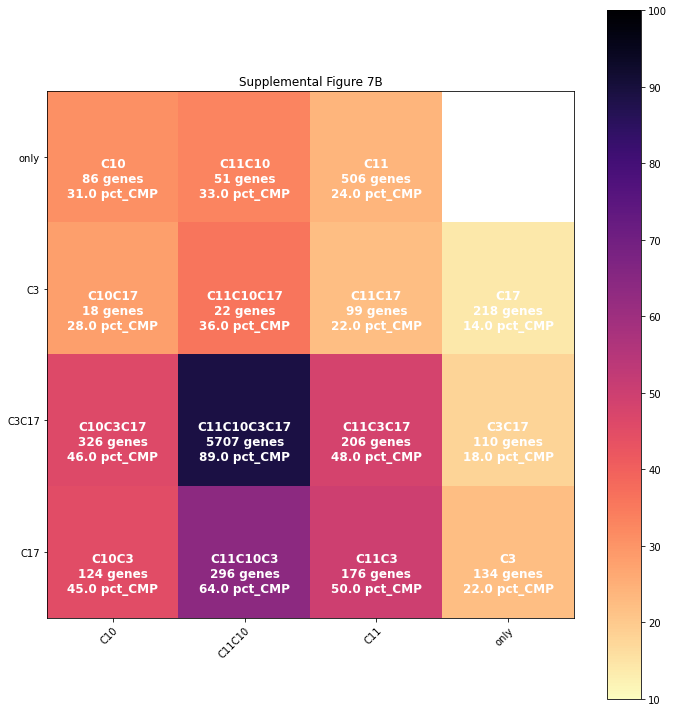

In [13]:
xaxis = ['C10', 'C11C10', 'C11', 'only']
yaxis = ['only', 'C3', 'C3C17', 'C17']

fig, ax = plt.subplots(figsize = (10, 10))
im = ax.imshow(graph_color, cmap='magma_r', vmin= 10, vmax = 100)
fig.colorbar(im)

# Show all ticks...
ax.set_xticks(np.arange(len(xaxis)))
ax.set_yticks(np.arange(len(yaxis)))
# Label them 
ax.set_xticklabels(xaxis)
ax.set_yticklabels(yaxis)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(xaxis)):
    for j in range(len(yaxis)):
        if not str(graph_value[i, j]) == 'nan':
            text = ax.text(j, i, ''.join((keyorder[i,j], '\n', str(graph_value[i, j]), ' genes', '\n', str(graph_color[i,j]), ' pct_CMP', '\n')),
                           ha="center", va="top", color="w", fontweight = 'bold', fontsize = 'large')

ax.set_title("Supplemental Figure 7B")
fig.tight_layout()
plt.show() # Note that in the text, figure is rotated 270 degrees (diamond format)

### Lineage gene expression profiles

In [14]:
hm_list = ["Gata2", "Runx1", "Pf4", "Meis1", 
           "Itga2b", "Itgb3", "Fli1", "Gata1", 
           "Klf1", "Zfpm1", "Tal1", 'Hba-a1',
           "Nfe2", "Vwf", 'Elane', 'Flt3', 
           'Epor', 'Irf8', 'Ly86', 'Cd9', 
           'Hbb-bt', 'Gfi1']

In [15]:
tpm_threshold = 10

# Filter out rows with all values < TPM threshold (all of)
filteredDF = TPM_avg.loc[~(TPM_avg[['CMPavg', 'C10avg', 'C11avg', 'C17avg', 'C3avg']] < 10).all(axis = 1)][['CMPavg', 'C10avg', 'C11avg', 'C17avg', 'C3avg', 'symbol']]

# add minimum value to avoid infinities during log conversions
correction_value = filteredDF[filteredDF[['CMPavg', 'C10avg', 'C11avg', 'C17avg', 'C3avg']]>0].min()/10**10
filteredDF[['CMPavg', 'C10avg', 'C11avg', 'C17avg', 'C3avg']]  += correction_value[['CMPavg', 'C10avg', 'C11avg', 'C17avg', 'C3avg']]

# Log2 transform
filteredDF[['CMPavg', 'C10avg', 'C11avg', 'C17avg', 'C3avg']] = np.log2(filteredDF[['CMPavg', 'C10avg', 'C11avg', 'C17avg', 'C3avg']])

# Clean up
filteredDF.index = filteredDF['symbol']



#### Supplemental Figure 7C

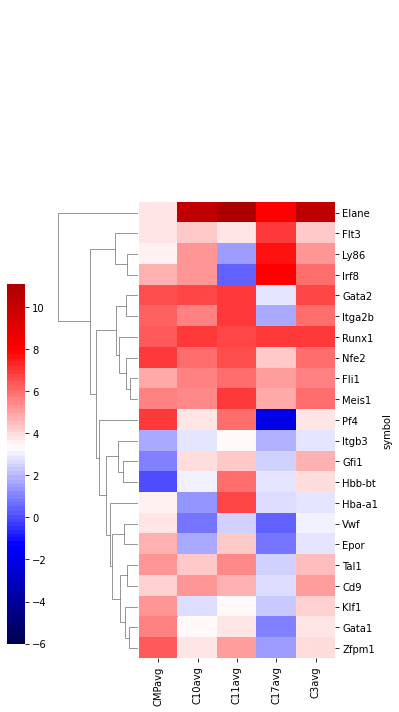

In [16]:
# Plot
cm = sns.clustermap(filteredDF.loc[filteredDF.index.isin(hm_list)][['CMPavg', 'C10avg', 'C11avg', 'C17avg', 'C3avg']], 
                    center = np.log2(10),
                    vmin = -6, 
                    figsize=(5, 10), 
                    col_cluster = False, 
                    yticklabels = True,
                    dendrogram_ratio = 0.3, 
                    cmap = sns.color_palette("seismic", n_colors=100), 
                    cbar_pos = (-.1, .1, 0.05, 0.5), 
                   )